In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pathlib import Path
path = Path('gdrive/My Drive/Project Implementation/')

#Data Collection


In [0]:
!wget https://goo.gl/8hY5ER
!tar xf 8hY5ER

--2019-03-25 10:53:41--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 64.233.184.138, 64.233.184.113, 64.233.184.101, ...
Connecting to goo.gl (goo.gl)|64.233.184.138|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2019-03-25 10:53:41--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘8hY5ER’

8hY5ER              100%[===================>]   5.61G  35.1MB/s    in 2m 47s  

2019-03-25 10:56:29 (34.4 MB/s) - ‘8hY5ER’ saved [6023741708/6023741708]



# Data Exploration and Analysis

In [0]:
import IPython.display as ipd

ipd.Audio('UrbanSound8K/audio/fold1/101415-3-0-2.wav')

**Visual inspection**

We will load a sample from each class and visually inspect the data for any patterns. We will use librosa to load the audio file into an array then librosa.display and matplotlib to display the waveform.

In [0]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [0]:
labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

def fig(filename):
  class_id = int(filename.split('-')[-3])
  print(labels[class_id])
  plt.figure(figsize=(12,4))
  data,sample_rate = librosa.load(filename)
  _ = librosa.display.waveplot(data,sr=sample_rate)
  ipd.Audio(filename)

air_conditioner


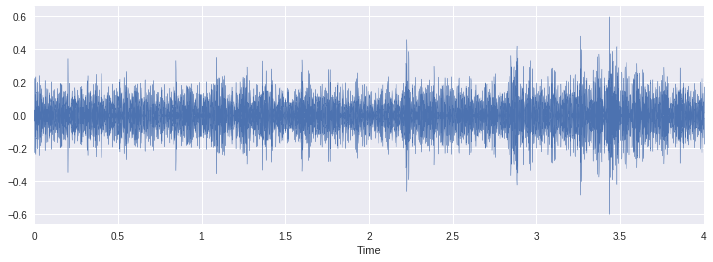

In [0]:
fig('UrbanSound8K/audio/fold1/134717-0-0-22.wav')

children_playing


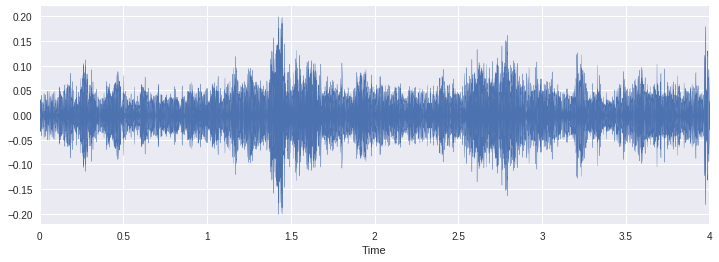

In [0]:
fig('UrbanSound8K/audio/fold1/105415-2-0-8.wav')

dog_bark


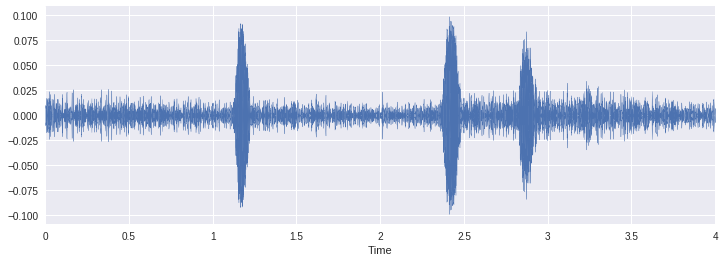

In [0]:
fig('UrbanSound8K/audio/fold1/102842-3-0-1.wav')

drilling


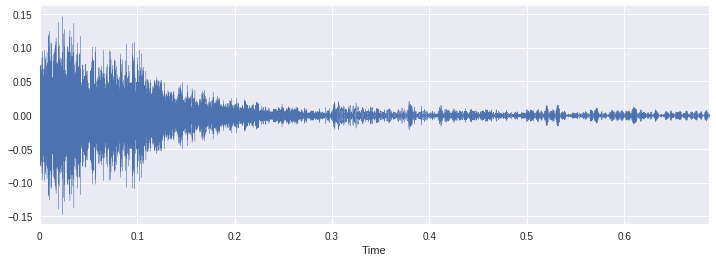

In [0]:
fig('UrbanSound8K/audio/fold1/147764-4-8-0.wav')

engine_idling


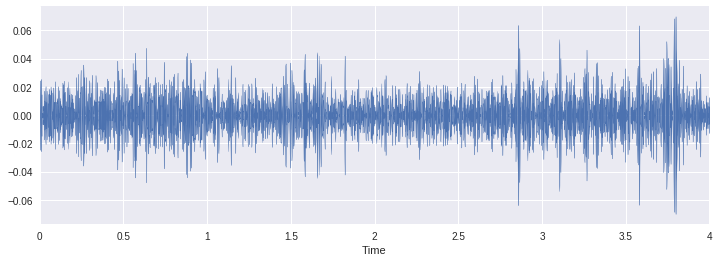

In [0]:
fig('UrbanSound8K/audio/fold1/103258-5-0-18.wav')

gun_shot


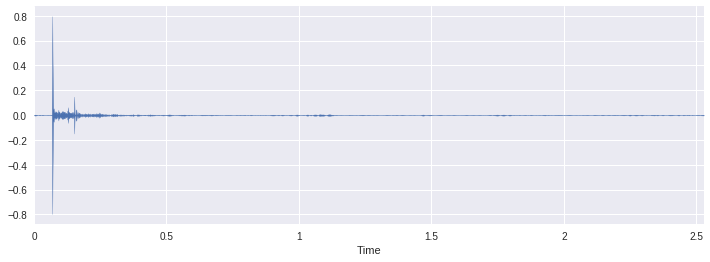

In [0]:
fig('UrbanSound8K/audio/fold1/174290-6-1-0.wav')

jackhammer


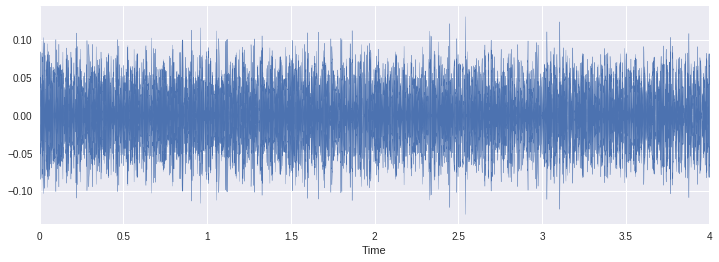

In [0]:
fig('UrbanSound8K/audio/fold1/103074-7-0-1.wav')

**Observations**

From a visual inspection we can see that it is tricky to visualise the difference between some of the classes.

Particularly, the waveforms for reptitive sounds for air conditioner, drilling, engine idling and jackhammer are similar in shape.

Likewise the peak in the dog barking sample is simmilar in shape to the gun shot sample (albeit the samples differ in that there are two peaks for two gunshots compared to the one peak for one dog bark). Also, the car horn is similar too.

There are also similarities between the children playing and street music.

The human ear can naturally detect the difference between the harmonics, it will be interesting to see how well a deep learning model will be able to extract the necessary features to distinguish between these classes.

However, it is easy to differentiate from the waveform shape, the difference between certain classes such as dog barking and jackhammer.

**Dataset Metadata**

Here we will load the UrbanSound metadata .csv file into a Panda dataframe.

In [0]:
import pandas as pd
data = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

**Class distributions **

In [0]:
data['class'].value_counts()

dog_bark            1000
children_playing    1000
drilling            1000
street_music        1000
engine_idling       1000
jackhammer          1000
air_conditioner     1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

**Observations**

Here we can see the Class labels are unbalanced. Although 7 out of the 10 classes all have exactly 1000 samples, and siren is not far off with 929, the remaining two (car_horn, gun_shot) have significantly less samples at 43% and 37% respectively.

This will be a concern and something we may need to address later on.

# Data PreProcessing and Spliting

**Sample rate conversion**

By default, Librosa’s load function converts the sampling rate to 22.05 KHz which we can use as our comparison level.

In [0]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = 'UrbanSound8K/audio/fold1/101415-3-0-2.wav'

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 48000
Librosa sample rate: 22050


Librosa will also convert the signal to mono, meaning the number of channels will always be 1.



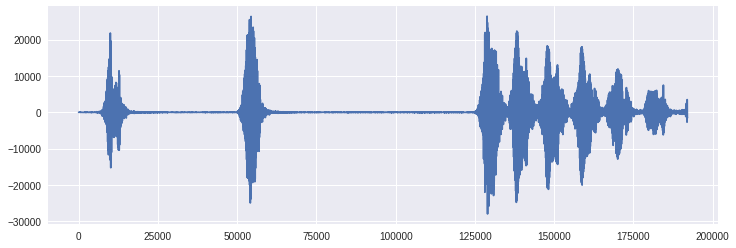

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

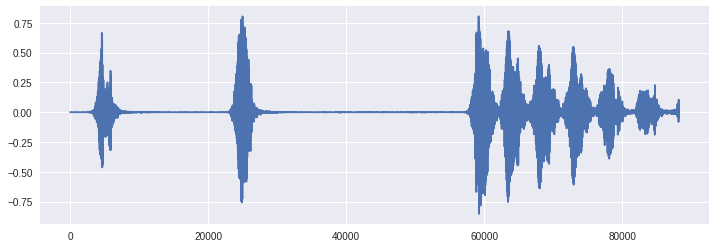

In [0]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

**Extract Features**

we will extract Mel-Frequency Cepstral Coefficients (MFCC) from the the audio samples.

The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.



**Extracting a MFCC**

For this we will use Librosa's mfcc() function which generates an MFCC from time series audio data.

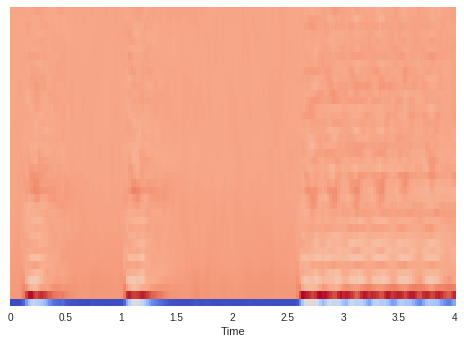

In [0]:
import librosa.display
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [0]:
import os
for index, row in data.iterrows():
  file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
  print(file_name)
  print(index,row)
  break

/content/UrbanSound8K/audio/fold5/100032-3-0-0.wav
0 slice_file_name    100032-3-0-0.wav
fsID                         100032
start                             0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
Name: 0, dtype: object


In [0]:
ans = extract_features('UrbanSound8K/audio/fold1/101415-3-0-2.wav');ans

gdrive/My Drive/Project Implementation/spectograms/101415-3-0-2.png


'101415-3-0-2.png'

**Extracting MFCC's for every file**

We will now extract an MFCC for each audio file in the dataset and store it in a Panda Dataframe along with it's classification label.

In [0]:
!rm -rf spectogram/
!mkdir spectogram

In [0]:
def extract_features(filename):
    print(filename)
    samples,sample_rate = librosa.load(filename)
    fig = plt.figure(figsize=[0.72,0.72])
    ax  = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    file_name = path/Path('spectograms/')/Path(filename).name.replace('.wav','.png')
    S = librosa.feature.melspectrogram(y=samples,sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    #plt.savefig(file_name, dpi=400, bbox_inches='tight',pad_inches=0)
    print(file_name)
    plt.close()
    return str(file_name).split('/')[-1]
    

SyntaxError: ignored

In [0]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy

# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'UrbanSound8K/audio/'

metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features
i = 0
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    #data = extract_features(file_name)
    file = Path(file_name).name.replace('.wav','.png')
    i+=1
    print(i)
    features.append([file, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['filename','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
featuresdf.to_csv(path/'data.csv',index=False)

In [0]:
data = pd.read_csv(path/'data.csv');data.head()

filename       class_label
0    100032-3-0-0.png          dog_bark
1  100263-2-0-117.png  children_playing
2  100263-2-0-121.png  children_playing
3  100263-2-0-126.png  children_playing
4  100263-2-0-137.png  children_playing

# Audio Modeling

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
src = (ImageList.from_csv(path,'data.csv',folder='spectograms')
       .split_by_rand_pct(0.3)
       .label_from_df())

In [0]:
data = (src.transform(tfms=None,size=128)
       .databunch(bs=64)
       .normalize(imagenet_stats))

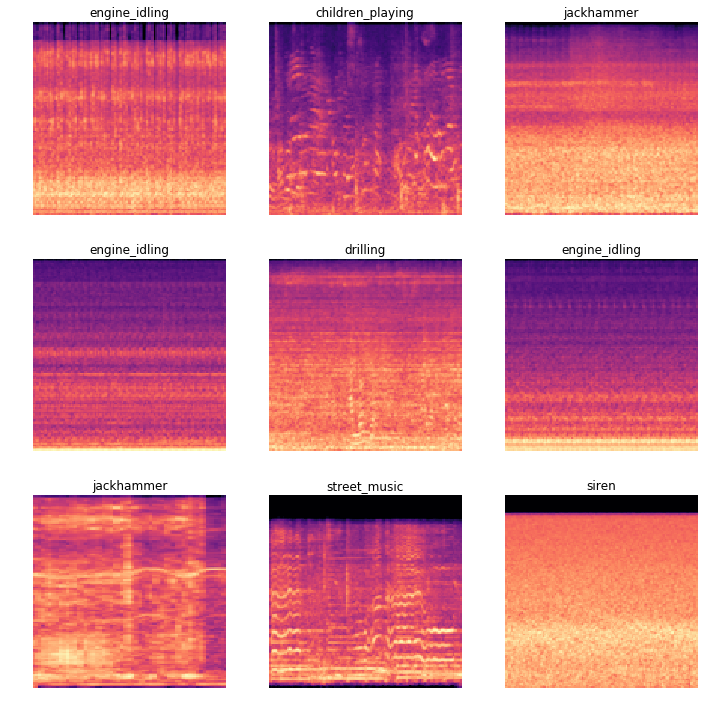

In [0]:
data.show_batch(rows=3,figsize=(10,10))

In [0]:
len(data.train_ds),len(data.valid_ds)

(6113, 2619)

# Resnet-34

In [0]:
learn = create_cnn(data,models.resnet34,metrics=(error_rate,accuracy))

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 66170961.82it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


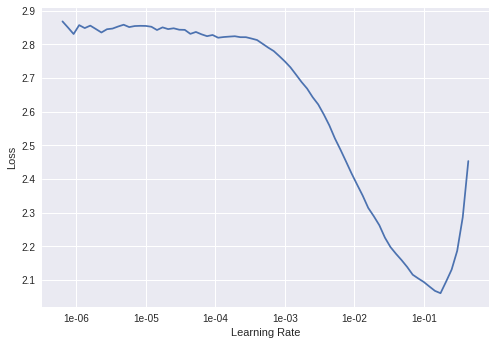

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6,1e-2)

In [0]:
learn.save('stage-1-34-acc-94')

In [0]:
learn.load('stage-1-34-acc-94')

.................Fine tuning whole model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


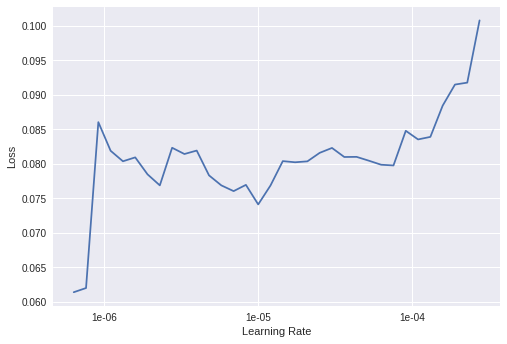

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,slice(1e-6,1e-5/2))

In [0]:
learn.save('stage-2-34-acc-95')

In [0]:
learn.load('stage-2-34-acc-95')

Learner(data=ImageDataBunch;

Train: LabelList (6113 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
children_playing,children_playing,children_playing,children_playing,children_playing
Path: gdrive/My Drive/Project Implementation;

Valid: LabelList (2619 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
drilling,dog_bark,air_conditioner,drilling,dog_bark
Path: gdrive/My Drive/Project Implementation;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3

# Resnet-50

In [0]:
data = (src.transform(tfms=False,size=256)
       .databunch(bs=64)
       .normalize(imagenet_stats))

In [0]:
learn = cnn_learner(data,models.resnet50,metrics=(error_rate,accuracy))

NameError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


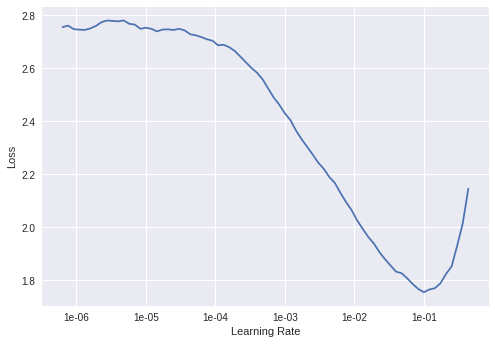

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,1e-2)

In [0]:
learn.save('stage-1-50-acc-95')

.....Fine tuning whole model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


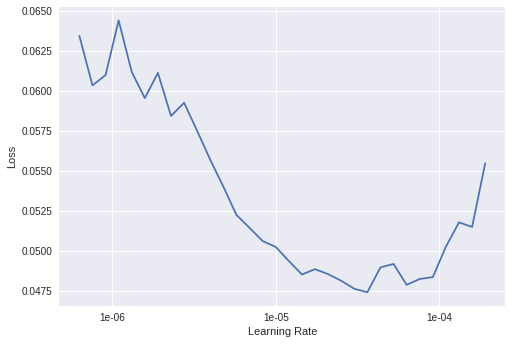

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,slice(1e-7,1e-5))

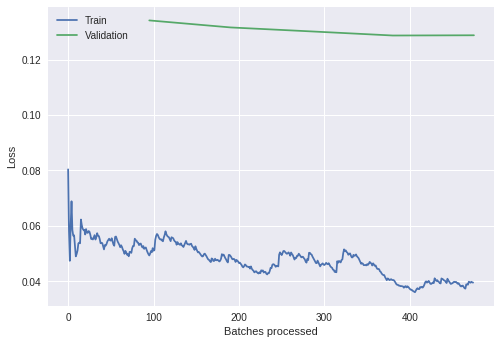

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-50-acc-9572')

# Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

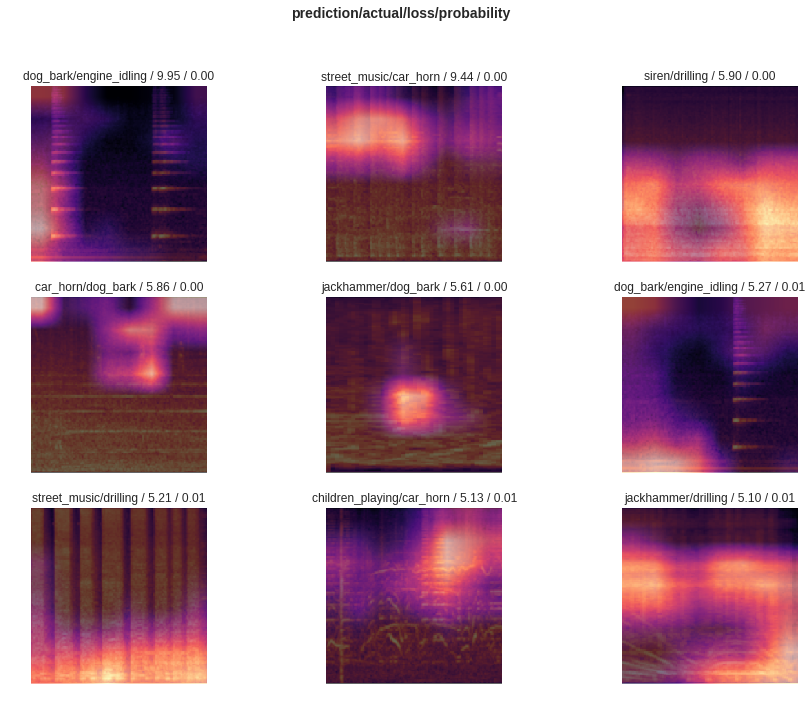

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

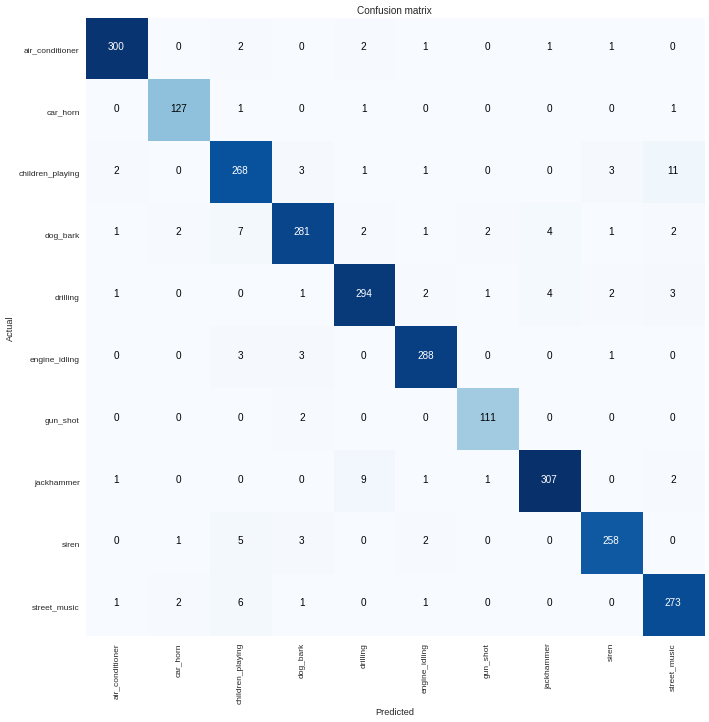

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('children_playing', 'street_music', 11),
 ('jackhammer', 'drilling', 9),
 ('dog_bark', 'children_playing', 7),
 ('street_music', 'children_playing', 6),
 ('siren', 'children_playing', 5),
 ('dog_bark', 'jackhammer', 4),
 ('drilling', 'jackhammer', 4),
 ('children_playing', 'dog_bark', 3),
 ('children_playing', 'siren', 3),
 ('drilling', 'street_music', 3),
 ('engine_idling', 'children_playing', 3),
 ('engine_idling', 'dog_bark', 3),
 ('siren', 'dog_bark', 3),
 ('air_conditioner', 'children_playing', 2),
 ('air_conditioner', 'drilling', 2),
 ('children_playing', 'air_conditioner', 2),
 ('dog_bark', 'car_horn', 2),
 ('dog_bark', 'drilling', 2),
 ('dog_bark', 'gun_shot', 2),
 ('dog_bark', 'street_music', 2),
 ('drilling', 'engine_idling', 2),
 ('drilling', 'siren', 2),
 ('gun_shot', 'dog_bark', 2),
 ('jackhammer', 'street_music', 2),
 ('siren', 'engine_idling', 2),
 ('street_music', 'car_horn', 2)]

# Testing Model

In [0]:
!git clone https://github.com/mikesmales/Udacity-ML-Capstone.git

Cloning into 'Udacity-ML-Capstone'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 52 (delta 6), reused 48 (delta 5), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [0]:
ans = Path("Udacity-ML-Capstone/Evaluation audio/");
t = list(ans.ls());
print(t[3])
prediction(t[3])

Udacity-ML-Capstone/Evaluation audio/siren_1.wav


(Category dog_bark,
 tensor(3),
 tensor([4.2245e-05, 3.5339e-06, 2.1313e-01, 6.7136e-01, 1.0082e-05, 2.2761e-04,
         6.6562e-05, 8.1668e-06, 1.1487e-01, 2.8072e-04]))

In [0]:
def prediction(filename):
    try:
      os.mkdir('testing')
    except:
      pass
    samples,sample_rate = librosa.load(filename)
    fig = plt.figure(figsize=[0.72,0.72])
    ax  = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    file_name = Path('testing/')/Path(filename).name.replace('.wav','.png')
    S = librosa.feature.melspectrogram(y=samples,sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.savefig(file_name, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()
    img = open_image(file_name)
    return learn.predict(img)

In [0]:
for i in t:
  print(i)
  sample,sample_rate = librosa.load(i)
  print(len(sample),sample_rate)

Udacity-ML-Capstone/Evaluation audio/dog_bark_1.wav
19340 22050
Udacity-ML-Capstone/Evaluation audio/gun_shot_1.wav
67209 22050
Udacity-ML-Capstone/Evaluation audio/drilling_1.wav
56373 22050
Udacity-ML-Capstone/Evaluation audio/siren_1.wav
101983 22050


In [0]:
aa = "Dogs Barking-SoundBible.com-625577590.wav"

In [0]:
sample,sample_rate = librosa.load(aa);
sample_rate,len(sample)

(22050, 170691)

In [0]:
prediction(aa)

(Category dog_bark,
 tensor(3),
 tensor([4.2245e-05, 3.5339e-06, 2.1313e-01, 6.7136e-01, 1.0082e-05, 2.2761e-04,
         6.6562e-05, 8.1668e-06, 1.1487e-01, 2.8072e-04]))

In [0]:
import IPython.display as ipd

ipd.Audio(aa)

# export


In [0]:
from fastai import *
from fastai.vision import *

In [0]:
learn.export()

In [0]:
learn = load_learner(path,'export.pkl')